In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
from sklearn.model_selection import GridSearchCV

import pandas as pd

import re
import nltk
from nltk.corpus import stopwords
import unicodedata

import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS
from IPython.display import display
import seaborn as sns
from PIL import Image


In [7]:
data = pd.read_csv("../data/BBC News Train.csv")
data.head()

,ArticleId,Text,Category
0,1833,worldcom ex-boss launches defence lawyers defe...,business
1,154,german business confidence slides german busin...,business
2,1101,bbc poll indicates economic gloom citizens in ...,business
3,1976,lifestyle governs mobile choice faster bett...,tech
4,917,enron bosses in $168m payout eighteen former e...,business


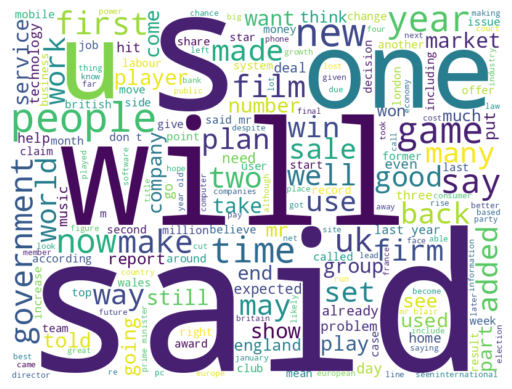

In [15]:
unprocessed_text = ' '.join(data["Text"].tolist())
wordcloud = WordCloud(background_color='white', width=800, height=600, random_state=42)
wordcloud.generate(text=unprocessed_text)

wordcloud.to_file("../figures/unprocessed_text_wordcloud.jpg")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [16]:
data["Text"] = data["Text"].apply(lambda text: re.sub(r'[^\w\s]', '', text))
data["Text"] = data["Text"].str.lower()

In [20]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /home/reikia/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [21]:
stop_words = set(stopwords.words('english'))

data["Text"] = data["Text"].apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))

In [22]:
data["Text"] = data["Text"].apply(lambda text: re.sub(r'<[^>]+>', '', text))

In [23]:
data["Text"] = data["Text"].str.strip()
data["Text"] = data["Text"].str.replace('\s+', ' ')

In [24]:
data["Text"] = data["Text"].apply(lambda text: unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8'))

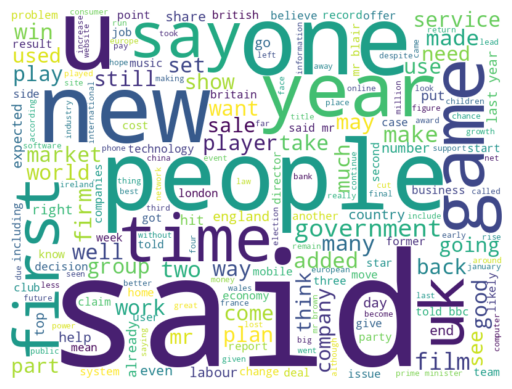

In [26]:
unprocessed_text = ' '.join(data["Text"].tolist())
wordcloud = WordCloud(background_color='white', width=800, height=600, random_state=42)
wordcloud.generate(text=unprocessed_text)

wordcloud.to_file("../figures/processed_text_wordcloud.jpg")

plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [27]:
sample_text = data["Text"].head(3).tolist()
for text in sample_text:
    print(text)

worldcom exboss launches defence lawyers defending former worldcom chief bernie ebbers battery fraud charges called company whistleblower first witness cynthia cooper worldcom exhead internal accounting alerted directors irregular accounting practices us telecoms giant 2002 warnings led collapse firm following discovery 11bn 57bn accounting fraud mr ebbers pleaded guilty charges fraud conspiracy prosecution lawyers argued mr ebbers orchestrated series accounting tricks worldcom ordering employees hide expenses inflate revenues meet wall street earnings estimates ms cooper runs consulting business told jury new york wednesday external auditors arthur andersen approved worldcom accounting early 2001 2002 said andersen given green light procedures practices used worldcom mr ebber lawyers said unaware fraud arguing auditors alert problems ms cooper also said shareholder meetings mr ebbers often passed technical questions company finance chief giving brief answers prosecution star witness f

/tmp/ipykernel_12859/2389686127.py:1: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(x="Category", data=data, palette="Set2")


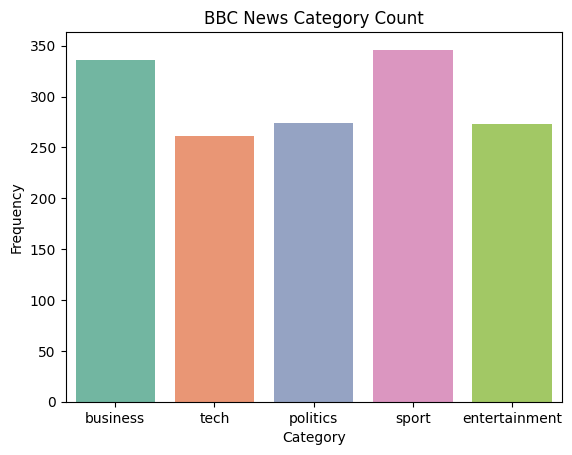

In [28]:
sns.countplot(x="Category", data=data, palette="Set2")
plt.title("BBC News Category Count")
plt.xlabel("Category")
plt.ylabel("Frequency")
plt.savefig("../figures/countplot_category_bbc.jpg")
plt.show()

In [30]:
texts = data["Text"].tolist()
categories = data["Category"].map({"business": 0, "tech": 1, "politics": 2, "sport": 3, "entertainment": 4})

In [57]:
vectorizer = TfidfVectorizer()
vectorized_texts = vectorizer.fit_transform(texts)

base_svd = TruncatedSVD()

params = {'n_components': [10, 20, 50, 100]}
grid = GridSearchCV(base_svd, params, scoring='accuracy')

grid.fit(vectorized_texts, categories)

best_model = grid.best_estimator_
best_components = grid.best_params_['n_components']



/home/reikia/anaconda3/envs/gan-project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py:993: UserWarning: Scoring failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/home/reikia/anaconda3/envs/gan-project/lib/python3.11/site-packages/sklearn/model_selection/_validation.py", line 982, in _score
    scores = scorer(estimator, X_test, y_test, **score_params)
             ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/reikia/anaconda3/envs/gan-project/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 253, in __call__
    return self._score(partial(_cached_call, None), estimator, X, y_true, **_kwargs)
           ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/reikia/anaconda3/envs/gan-project/lib/python3.11/site-packages/sklearn/metrics/_scorer.py", line 344, in _score
    response_method = _check_response_method(

In [49]:
print(best_components)

5


In [58]:
test_data = pd.read_csv("../data/BBC News Test.csv")
test_data.head()

,ArticleId,Text
0,1018,qpr keeper day heads for preston queens park r...
1,1319,software watching while you work software that...
2,1138,d arcy injury adds to ireland woe gordon d arc...
3,459,india s reliance family feud heats up the ongo...
4,1020,boro suffer morrison injury blow middlesbrough...


In [59]:
test_data["Text"] = test_data["Text"].apply(lambda text: re.sub(r'[^\w\s]', '', text))
test_data["Text"] = test_data["Text"].str.lower()
test_data["Text"] = test_data["Text"].apply(lambda text: ' '.join([word for word in text.split() if word not in stop_words]))
test_data["Text"] = test_data["Text"].apply(lambda text: re.sub(r'<[^>]+>', '', text))
test_data["Text"] = test_data["Text"].str.strip()
test_data["Text"] = test_data["Text"].str.replace('\s+', ' ')
test_data["Text"] = test_data["Text"].apply(lambda text: unicodedata.normalize('NFKD', text).encode('ASCII', 'ignore').decode('utf-8'))

In [61]:
category_list = []

for idx, row in test_data.iterrows():
    vectorized_new_news = vectorizer.transform([row['Text']])
    similarities = grid.transform(vectorized_new_news)
    category_list.append(similarities.argmax())

test_data['Category'] = category_list

test_data.head()

,ArticleId,Text,Category
0,1018,qpr keeper day heads preston queens park range...,0
1,1319,software watching work software monitor every ...,0
2,1138,arcy injury adds ireland woe gordon arcy ruled...,6
3,459,india reliance family feud heats ongoing publi...,0
4,1020,boro suffer morrison injury blow middlesbrough...,0


In [62]:
test_data["Category"] = test_data["Category"].map({0: "business", 1: "tech", 2: "politics", 3: "sport", 4: "entertainment"})
test_data['Category'].value_counts()

Category
business         571
sport             41
entertainment     41
tech              12
politics          11
Name: count, dtype: int64

In [63]:
test_data[['ArticleId', 'Category']].to_csv('../results/answer.csv', index=False)